In [8]:
import logging
import asyncio
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

# XXX temporary hack to import from src
try:
    path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(__file__))), "src")
except:
    path = "~/gith/domschl/indrajala/python_indrajala/src"
    # expand ~
    path = os.path.expanduser(path)
# print(path)
sys.path.append(path)

from indralib.indra_event import IndraEvent
from indralib.indra_client import IndraClient
from indralib.indra_downloader import IndraDownloader

2023-06-06 12:45:28,072 INFO matplotlib.font_manager Failed to extract font properties from /usr/share/fonts/noto/NotoColorEmoji.ttf: In FT2Font: Could not set the fontsize (invalid pixel size; error code 0x17)
2023-06-06 12:45:28,161 INFO matplotlib.font_manager generated new fontManager


In [6]:
logging.basicConfig(
    format="%(asctime)s %(levelname)s %(name)s %(message)s", level=logging.INFO
)
dl = IndraDownloader(cache_dir="geodata/cache")
dfs = dl.get_datasets(data_sources_dir="geodata/data_sources")
for df_name in dfs:
    print("-----------------------------------------------")
    print(df_name)
    print(dfs[df_name]["metadata"])
    print(dfs[df_name]["data"].head())
print(f"Number of datasets: {len(dfs)}")


2023-06-06 12:28:59,669 INFO Downloader processing: geodata/data_sources/11000yearsunspotnumber.toml
2023-06-06 12:29:01,137 INFO Downloader Read https://www.ncei.noaa.gov/pub/data/paleo/climate_forcing/solar_variability/solanki2004-ssn.txt from cache at geodata/cache/solanki2004-ssn.txt
2023-06-06 12:29:01,139 INFO Downloader Creating dataset sunspots11000yrs
2023-06-06 12:29:01,149 INFO Downloader processing: geodata/data_sources/CO2_800k_composite.toml
2023-06-06 12:29:01,948 INFO Downloader Read https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt from cache at geodata/cache/antarctica2015co2composite.txt
2023-06-06 12:29:01,949 INFO Downloader Creating dataset CO2_800k_composite
2023-06-06 12:29:01,962 INFO Downloader processing: geodata/data_sources/DWDGermanAugustMeanTemperature.toml
2023-06-06 12:29:02,245 INFO Downloader Read https://opendata.dwd.de/climate_environment/CDC/regional_averages_DE/monthly/air_temperature_mean/regional_averages

-----------------------------------------------
sunspots11000yrs
{'title': 'Solanki et al. 2004 11,000 Year Sunspot Number Reconstruction', 'description': 'Records of changes in solar irradiance, volcanic aerosols, atmospheric trace gases, and other properties thought to influence climate in the past. Parameter keywords describe what was measured in this data set. Additional summary information can be found in the abstracts of papers listed in the data set citations.', 'authors': ['Solanki, S.K.', 'Usoskin, I.G.', 'Kromer, B.', 'Schuessler, M.', 'Beer, J.'], 'publication_date': '2004-10-28', 'last_update': '2005-02', 'publisher': 'Environmental Research Letters, 11, 2, 024001', 'id': 'https://doi.org/10.25921/y6td-ne29', 'indra_id': 'solanki2004', 'indra_domain': '$event/geodata/paleo/{indra_id}/sunspots', 'version': '', 'data_source': 'https://www.ncei.noaa.gov/pub/data/paleo/climate_forcing/solar_variability/solanki2004-ssn.txt', 'related_publications': ['https://www.ncei.noaa.gov/ac

In [12]:
df = dfs["LawDome2018CO2"]['data']
df.head()

,SampleID,age_ice,age_CO2,CO2ppm,CO2err
0,DSSW20K 15.8,firn,1996,359.87,0.02
1,DSSW20K 29,firn,1994,357.24,0.04
2,DE08-2 0,firn,1993,354.60,0.02
3,DSSW20K 37.8,firn,1992,353.89,0.04
4,DE08-2 10,firn,1991,352.60,0.18


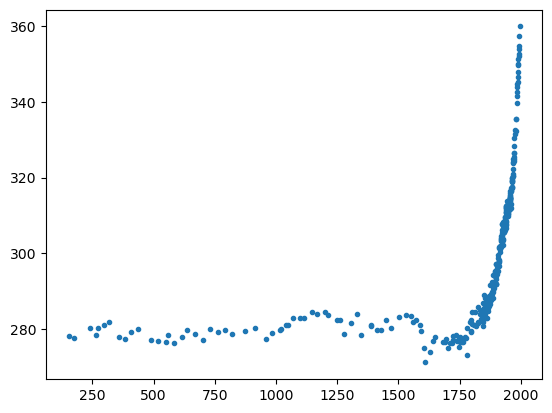

In [15]:
plt.plot(df['age_CO2'], df['CO2ppm'], '.')